# Machine learning with audio data - Preparation

In this and the next unit we will see how we can prepare, explore and analyze audio data with the help of machine learning. As for the other modalities, such as text or images, the trick is to get the data first into a machine interpretable format.

The interesting thing with audio data is that you can treat it as many different modalities:

- You can extract high-level features and analyze the data like tabular data.
- You can compute frequency plots and analyze the data like image data.
- You can use speech-to-text models and analyze the data like text data.
- You can use temporal sensitive models and analyze the data like time-series data.

In our course we will take a look at the first three approaches. But first, let’s take a closer look at what audio data.

The data we will be using for this use-case was downloaded from the Common Voice repository from Kaggle. This 14 GB big dataset is a small snapshot of a much bigger dataset from Mozilla. But don’t worry, for our use-case here we will use an ever smaller subsample of the full dataset, more about this later.

### 1. Audio data

While there are multiple Python libraries that allow you the loading and manipulation of audio data (scipy is one of them), we will use librosa for this and the following unit.

So, let’s download the sample_?.mp3 files from the resources of this unit and load them with librosa.

In [32]:
import numpy as np
import librosa

# Load the mp3 fille
y, sr = librosa.load("resources/c4_sample-1.mp3", sr=16_000)

# Print some imformation
print(y, len(y), sr)

[-6.54836185e-11  2.54658516e-11 -8.00355338e-11 ...  1.16259325e-05
  7.20215030e-05  5.71708661e-05] 50688 16000


>In the ``librosa.load()`` function call, ``sr`` is a parameter that specifies the sampling rate of the audio file to be loaded. Sampling rate refers to the number of samples of audio per second, and is typically measured in Hz (Hertz).
>- In this case, ``sr=16_000`` specifies a sampling rate of 16,000 Hz, which means that there are 16,000 audio samples per second in the loaded audio file. This value is often used in audio processing applications that require a lower sampling rate, such as speech recognition or audio compression.
>- Note that the choice of sampling rate may depend on various factors, such as the nature of the audio signal, the desired audio quality, or the processing tasks to be performed on the audio data.

The information we get from the audio file are y the audio time-series data represented as 50’688 individual data points and sr the sampling rate with which the audio data was read from the file (use sr=None to get the original sampling rate). To better understand what this time-series data contains, let’s plot it in a figure.

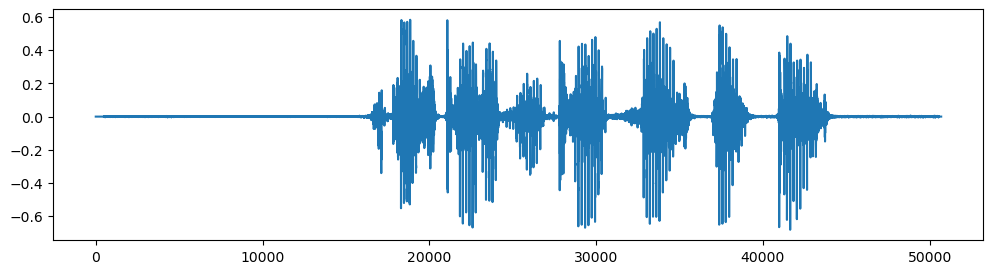

In [33]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(y)
plt.show()


What you see here is the waveform representation of the spoken sentence: “he just got a new kite for his birthday”. Don’t believe me? Go ahead and open the mp3 file with your favorite audio player. Or even more simple, you can use the following code to listen to the audio data directly in your notebook:

In [34]:
import IPython.display as ipd
ipd.Audio(y, rate=sr)

Instead of using the matplotlib ``plot()`` function, you can also use librosa’s ``waveshow()`` function, which helps to plot the right time scale on the x-axis.

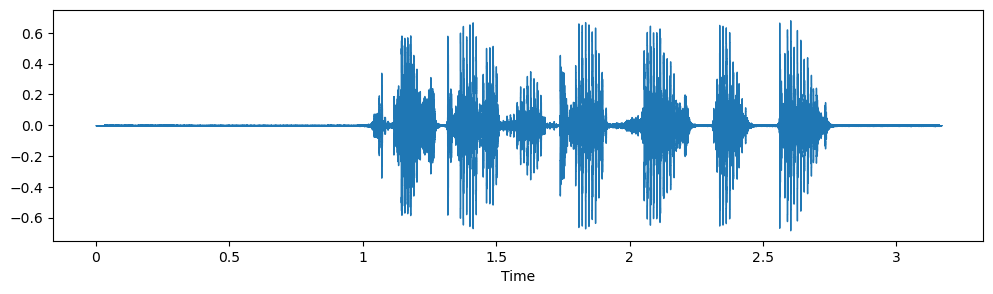

In [35]:
import librosa.display
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)

Waveform - signal in the time-domain
---
But did we call it time-series data or waveform? Well, let’s take a closer look at a small segment of this signal.

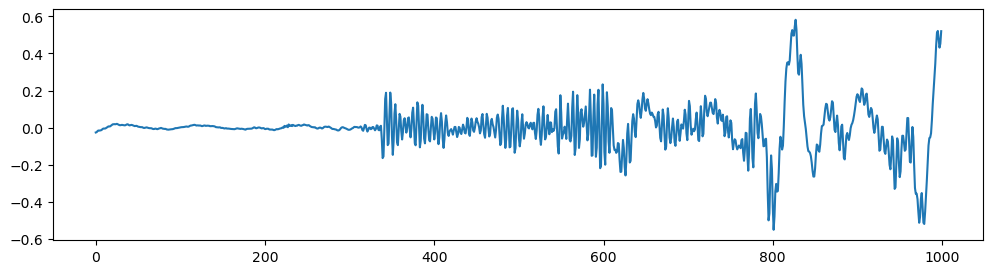

In [36]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(y[17500:18500])
plt.show()

What you can see is a temporal signal that oscillates around the value 0 with different frequencies and amplitudes.This signal represents the air pressure change over time, or the physical displacement of a loud speaker’s membrane (or the membrane in your ear for that matter). That’s why this depiction of the audio data is also called waveform.

The frequency is the speed with which this signal oscillates. Low frequency, e.g. 60 Hz could be the sound of bass guitar, while a birds sound could be in the higher frequency of 8000 Hz. Human speech is usually anywhere between that.

To know how quickly this signal needs to be interpret, we also need to know the sampling rate at which the data was recorded. In this case, the sampling rate per second was 16’000 or 16k Hz. Which means that the 1’000 time points we can see in the previous figure represents 62.5 milliseconds (1000/16000 = 0.0625) of audio signal.

In some cases you might be rather interested in the envelope of the audio signal than the oscillating waveform. In that case you can just can compute the envelope function with the following code:

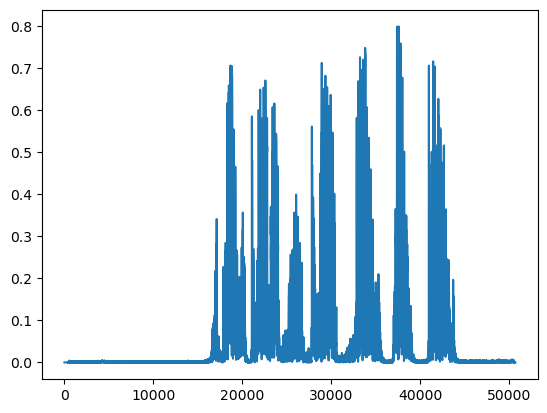

In [37]:
from scipy.signal import hilbert
y_envelope = np.abs(hilbert(y))

plt.plot(y_envelope);

The Fourier Transform - signal in the frequency domain
---
While the previous visualization can tell us when something happens (i.e. around 2 seconds there seem to be a lot of waveforms), it cannot really tell us with what frequency it happens. Because we have information about the when, this is signal representation is said to be in the time domain.

Using a fast fourier transformation, we can invert this issue and get a clear information about what frequencies are present, while loosing all information about the when. In such a case, the signal representation is said to be in the frequency domain.

Let’s see what our spoken sentence from before looks like represented in the frequency domain.

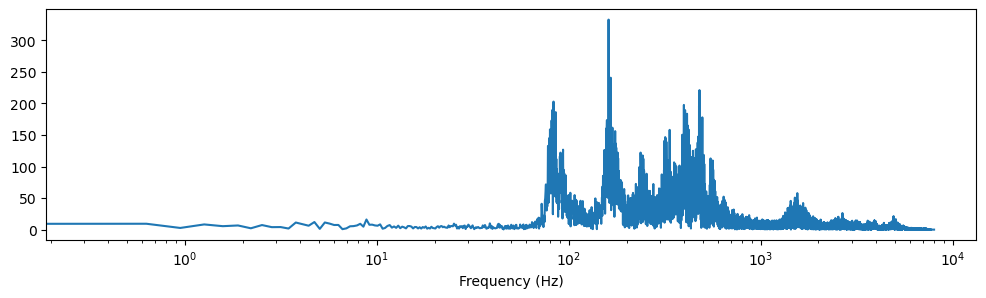

In [38]:
import scipy

# Applies fast fourier transformation to the signal and take absoluate values
y_freq = np.abs(scipy.fft.fft(y))

#  Establishes all possible frequency (dependent on the sampling rate and the length of the signal)
f = np.linspace(0, sr, len(y_freq))

# Plot audio signal as frequency information.
plt.figure(figsize=(12, 3))
#the floor division // rounds the result down to the nearest whole number
plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
plt.xlabel("Frequency (Hz)")
plt.show()

>The reason for using ``f[: len(f) // 2]`` is to only plot the positive half of the frequency spectrum of the signal. <br><br> 
In the Fourier transform of a real-valued signal, the spectrum is symmetric about the Nyquist frequency, which is half the sampling rate. The first half of the spectrum (up to the Nyquist frequency) contains the information about the positive frequencies, while the second half (beyond the Nyquist frequency) contains the information about the negative frequencies. Since the negative frequencies are just the mirror image of the positive frequencies, we can ignore them and only plot the positive half.

What you can see here is that most of the signal is somewhere between ~100 and ~1000 Hz (i.e. between 
10
2
 and 
10
3
), plus there seem to be some additional thing closer to 10’000 Hz.

Spectrogram
---
Luckily, we don’t always need to decide for either the time or frequency domain. Using a spectrogram plot, we can profit from both domains, while keeping most of the handicaps minimal. There are multiple ways how you can create such spectrogram plots, but for this use-case let’s take a look at three in particular.

While spectrogram plots are very useful, for some analysis you might prefer to only look at one of the domains alone.

A. Short-time Fourier transform (STFT)
---
Using a small adapted version of the fast fourier transformation before, namely the short-time fourier transformation (STFT), we can create such a spectrogram. The small trick that is applied here is that the FFT is computed for multiple small time windows (hence “short-time fourier”) in a sliding window manner.

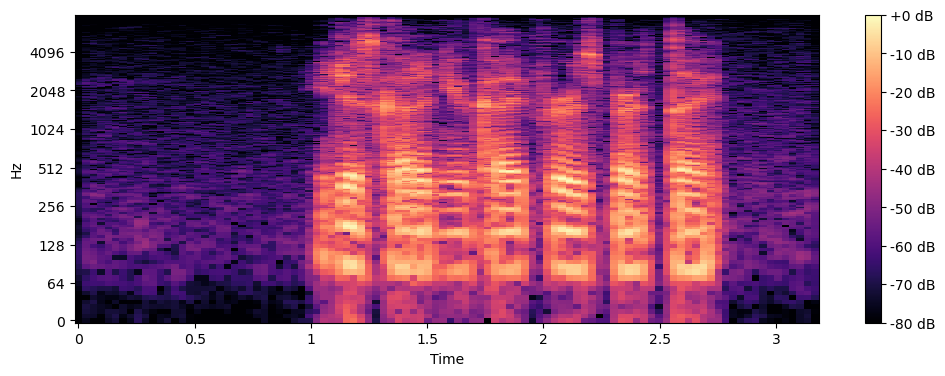

In [39]:
import librosa.display

# Compute short-time Fourier Transform
x_stft = np.abs(librosa.stft(y))

# Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)

# Plot STFT spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.show()

As in all spectrogram plots, the color represents the amount (loudness/volume) of a given frequency, at a given timepoint. +0dB is the loudest, and -80dB is silence. On the horizontal x-axis we can see the time, while on the vertical y-axis we can see the different frequencies.

The computation of these spectrogram plots, as well as their scaling can be influenced and changed by multiple different function parameters, such as n_fft, hop_length, win_length. The implication of changing these parameters would go into too much detail, but in short, they can control how detailed (i.e pixelated) the spectrogram plot looks.

B. Mel spectrogram
---
As an alternative to the STFT, you can also compute the mel spectrogram, which is based on the mel scale. This scale accounts for the way we human perceive a sounds pitch. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as having the same perceptual difference.

The mel spectrogram is computed very similar to the STFT, the main difference is just that the y-axis uses a different scale.

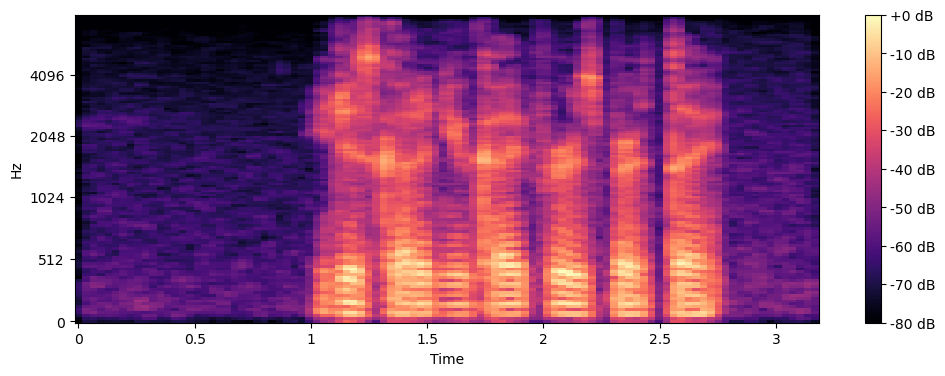

In [40]:
# Compute the mel spectrogram
x_mel = librosa.feature.melspectrogram(y=y, sr=sr)

# Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
x_mel = librosa.power_to_db(x_mel, ref=np.max)

# Plot mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_mel, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.show()


The difference to the STFT might not be too obvious first, but if you take a closer look, you can see that in the STFT plot, the frequency from 0 to 512 Hz take much more space on the y-axis than in the mel plot.

C. Mel-frequency cepstral coefficients (MFCCs)
----
The Mel-frequency cepstral coefficients (MFCCs) are an alternative representation of the mel spectrogram from before. The advantage of the MFCCs over the mel-spectrogram are the rather small number of features (i.e. horizontal lines on the y-axis), usually ~20.

Due to the fact that the mel spectrogram is closer to the way we human perceive pitch and that the MFCCs only has a few number of component features, must machine learning practitioner prefer the MFCCs over any other way for representing audio data in an ‘image way’. Which isn’t to say that for a given problem an STFT, mel or waveform representation might work better.

So, lets go ahead and compute the MFCCs and plot them.

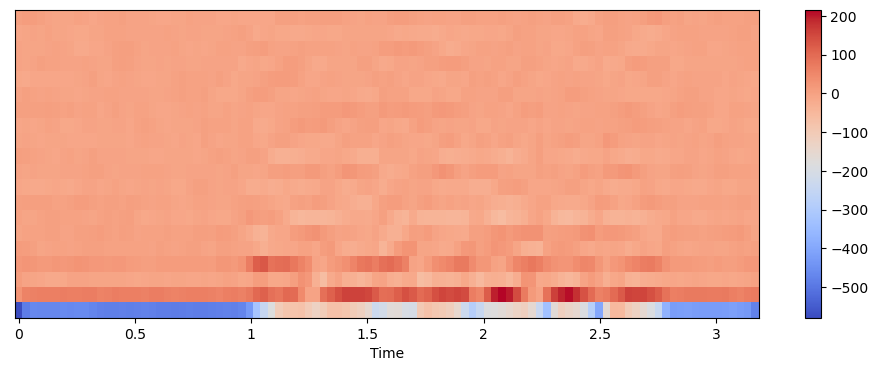

In [41]:
# Extract 'n_mfcc' numbers of MFCCs components (here 20)
x_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)


# Plot MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(x_mfccs, sr=sr, x_axis="time")
plt.colorbar()
plt.show()

Audio data recap
---
What we learned so far is that audio data can be represented in many different ways. While the raw data in waveform is very detailed, it has a lot of sample points to consider. This can become computationally very demanding for a machine learning model.



In [42]:
# Shape of the raw data in waveform
y.shape

(50688,)

To gain also some information from the frequency domain of an audio signal, we can compute spectrogram plots. While short-time Fourier transform (STFT) are the quickest way to get there, they are not addressing the way how we humans perceive pitch. For this we can compute the mel spectrogram, which as such scales the y-axis differently.

In [43]:
# Shape of the stft and mel spectrogram
x_stft.shape, x_mel.shape

((1025, 100), (128, 100))

To have an even more compact version of the mel spectrogram, and because it seems to be very useful for speech recognition and other audio based machine learning problems, we also introduced the Mel-frequency cepstral coefficients (MFCCs).

In [44]:
# Shape of the mfccs
x_mfccs.shape

(20, 100)

## 2. Data cleaning
Now that we understand a bit better what audio data looks like, let’s visualize a few more examples

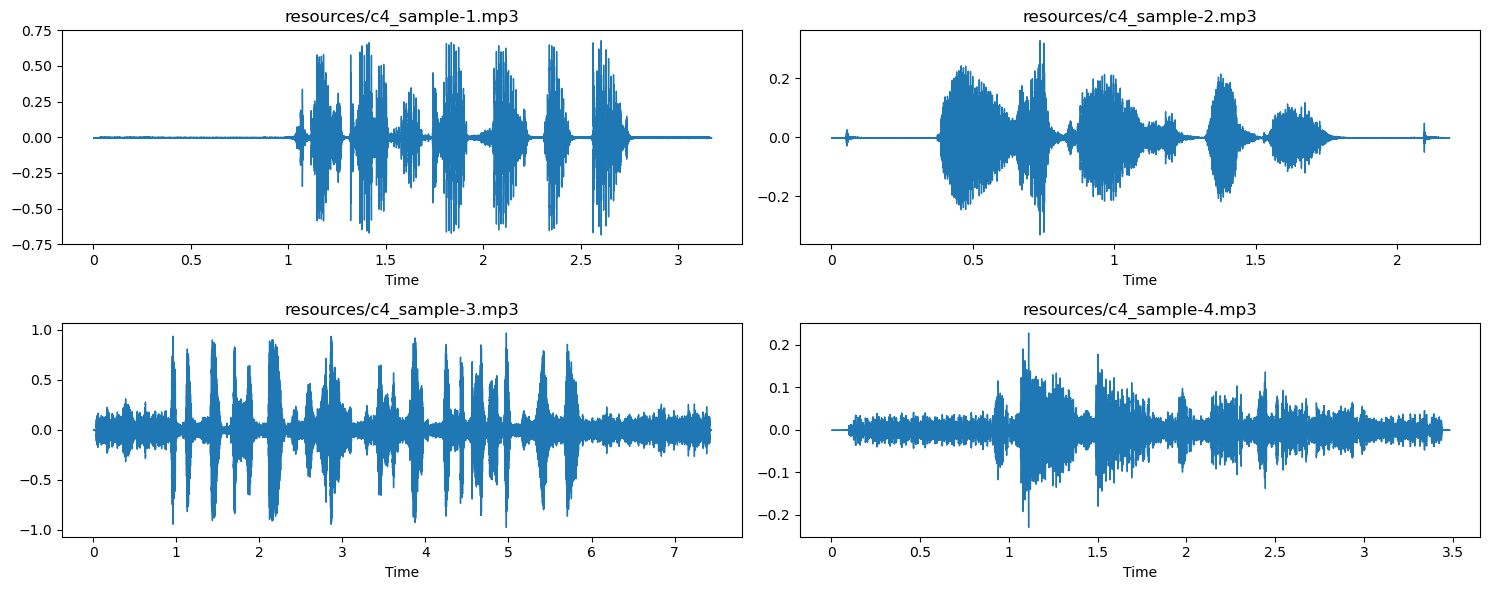

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    fname = "resources/c4_sample-%d.mp3" % (i + 1) # other way using f-string f"c4_sample-{i+1}.mp3"
    y, sr = librosa.load(fname, sr=16_000)
    # Plot
    librosa.display.waveshow(y, sr=sr, ax=ax)
    # Add title
    ax.set_title(fname)
plt.tight_layout()
plt.show()

>Here, ``"c4_sample-%d.mp3"`` is a string with the format specifier ``%d``, which is a __placeholder for a decimal integer__. The ``%`` operator is then used to substitute the value of ``(i + 1)`` into the ``%d`` __placeholder in the string__. This means that the final string will have the value of ``(i + 1)`` in place of ``%d``.
>- An f-string is a way to format strings that allows you to include expressions inside curly braces {}. Here's how you can use f-strings (``f`` before the string) to achieve the same result: ``f"c4_sample-{i+1}.mp3"``

From these four examples, and more importantly, when listening to them, we can gather a few more insights about this audio dataset:

1. Most recordings have a long silence period at the beginning and the end of the recording (see sample 1 and 2). This is something we should take care of with ‘trimming’.
2. However, in some cases, these silence period are interrupted by a ‘click’, due to the pressing and releasing of the recording buttons (see sample 2).
3. Some audio recording don’t have such silence phase, i.e. a straight line (see sample 3 and 4). When listening to these recordings we can observe that this is due to a lot of background noise.

To better understand how this is represented in the frequency domain, let’s look at the corresponding stft spectrogram. Note, we chose stft over mel here because in this particular example, the noise of sample 4 is in the lower frequency range.

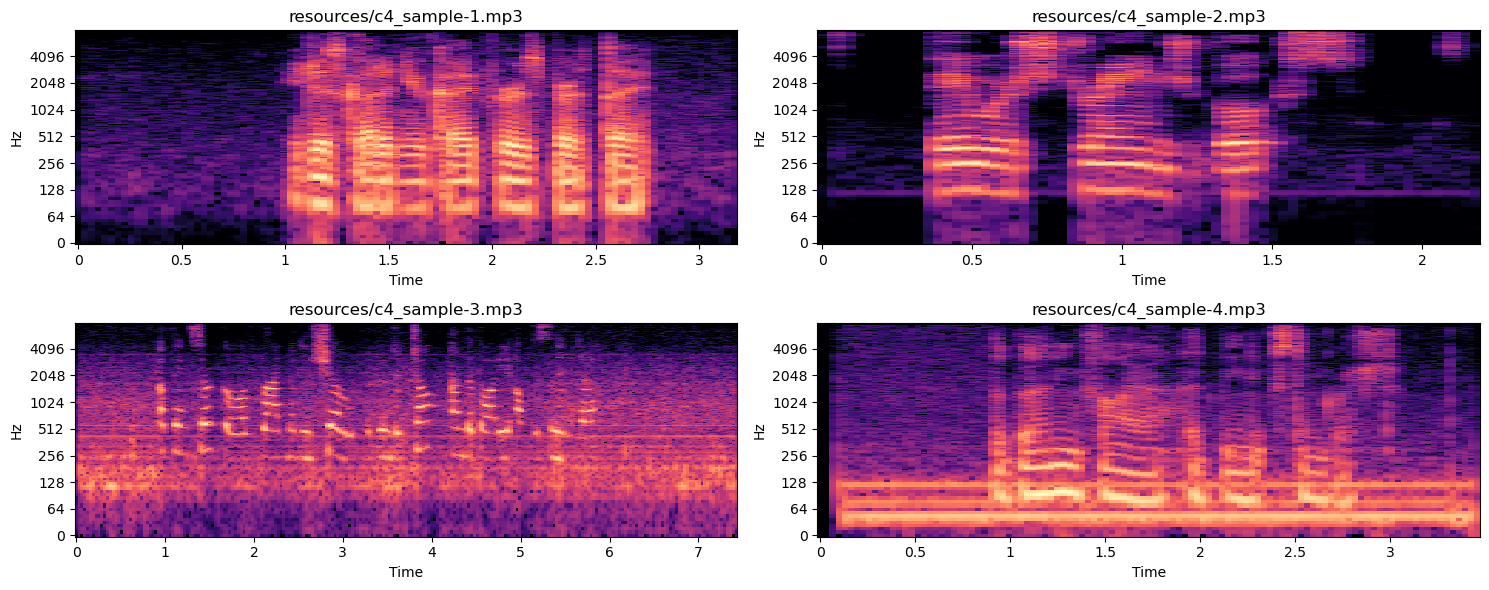

In [46]:
# The code is the same as before, using the stft-spectrogram routine
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "resources/c4_sample-%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    x_stft = np.abs(librosa.stft(y))
    x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)
    librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log", ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show()

In [47]:
# Listen to the audio
for i in range(4):
    fname = "resources/c4_sample-%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    display(ipd.Audio(y, rate=sr))

When we listen to the audio recordings we can observe that sample 3 has varying background noise covering multiple frequencies, while the background noise in sample 4 is rather constant. This is also what we see in the figures above. Sample 3 is very noisy throughout, while sample 4 has thick horizontal lines. While it is difficult to remove noise from sample 3, it is much simpler to remove it from sample 4. But now, we won’t go into more detail of how this can be done, as this would be beyond the scope of this unit.

So, for now, let’s look into a way of how we can remove this noise, and trim the audio samples. While a more manual approach, using custom filtering functions, might be the best approach to remove noise from audio data, in our case we will go ahead and use the practical python package noisereduce.

In [48]:
import noisereduce as nr
from scipy.io import wavfile

# Loop through all four samples
for i in range(4):
    # Load audio file
    fname = "resources/c4_sample-%d.mp3" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)

    # Remove noise from audio sample
    reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False)
    print(fname.replace(".mp3", ".wav"))

    # Save output in a wav file as mp3 cannot be saved to directly
    wavfile.write(fname.replace(".mp3", ".wav"), sr, reduced_noise)
    

resources/c4_sample-1.wav
resources/c4_sample-2.wav
resources/c4_sample-3.wav
resources/c4_sample-4.wav


In [49]:
# listen to the audio
for i in range(4):
    fname = "resources/c4_sample-%d.wav" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    display(ipd.Audio(y, rate=sr))

If you listen to the created wav files, you can hear that the noise is almost completely gone. Yes, we also introduced a few more artifacts, but overall, we hope that our noise removal approach did more good than harm.

For the trimming step we can use librosa’s ``.effects.trim()`` function. Note, each dataset might need a different ``top_db`` parameter for the trimming, so best is to try out a few versions and see what works well. In our case it is top_db=20.

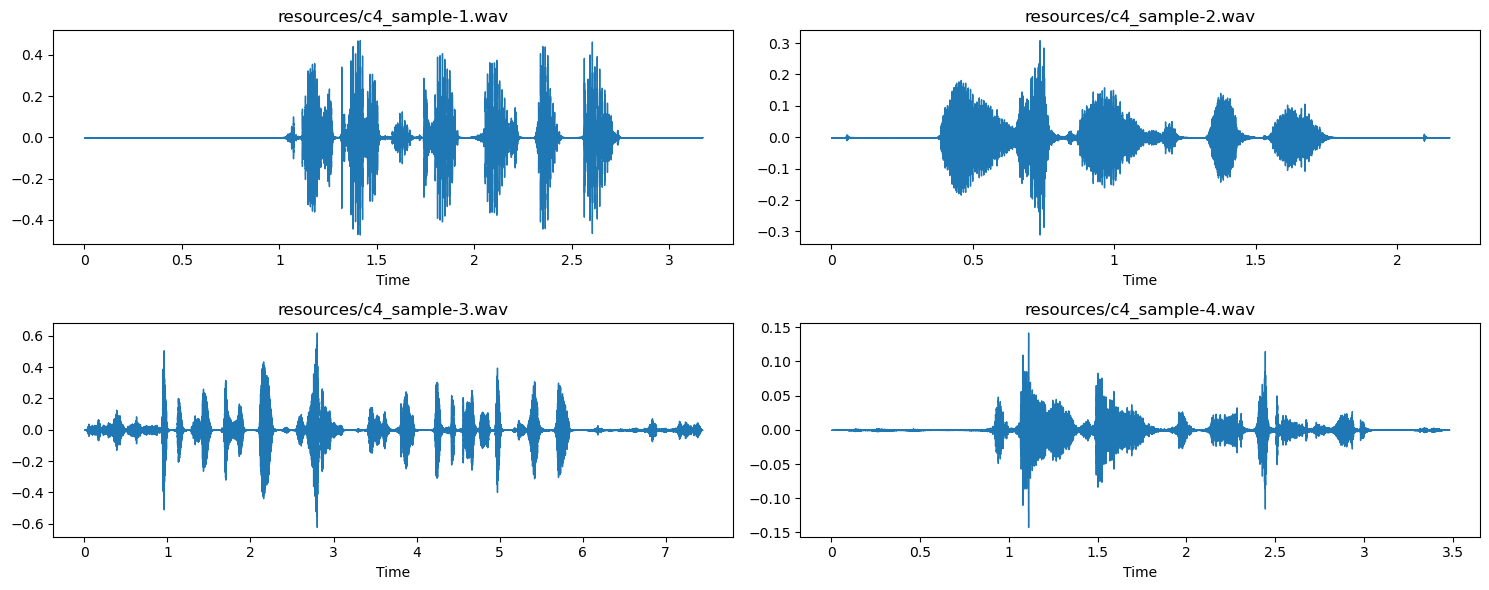

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "resources/c4_sample-%d.wav" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    librosa.display.waveshow(y=y, sr=sr, ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show()

In [51]:
# Loop through all four samples
for i in range(4):

    # Load audio file
    fname = "resources/c4_sample-%d.wav" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)

    # Trim signal
    y_trim, _ = librosa.effects.trim(y, top_db=20)
    print(fname.replace("resources/", ""))
    
    #  Overwrite previous wav file
    wavfile.write(fname.replace("resources/", ""), sr, y_trim)

c4_sample-1.wav
c4_sample-2.wav
c4_sample-3.wav
c4_sample-4.wav


Let’s now take another look at the cleaned data.

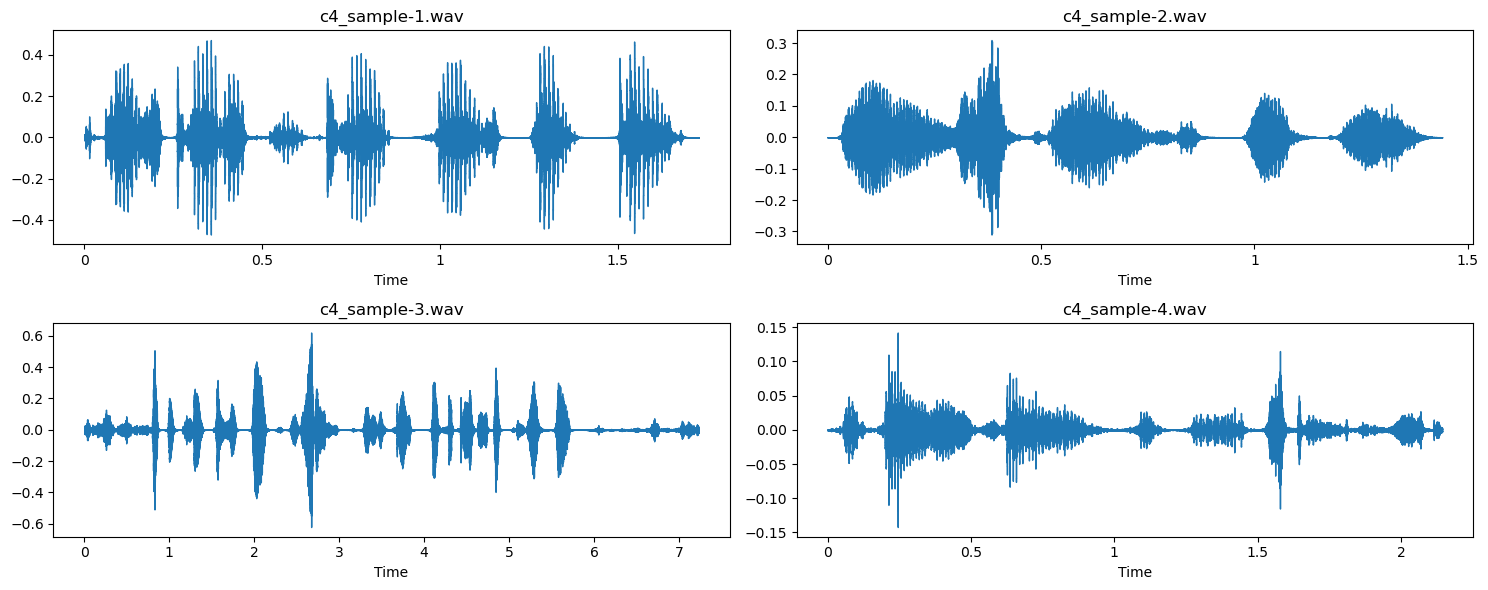

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    fname = "c4_sample-%d.wav" % (i + 1)
    y, sr = librosa.load(fname, sr=16_000)
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.set_title(fname)
plt.tight_layout()
plt.show()

Much better!

## 3. Feature extraction

Now that our data is clean, let’s go ahead and look into a few audio-specific feature that we could extract. But first, let’s load a file.

In [53]:
# Load data for sample 1
y, sr = librosa.load("c4_sample-1.wav", sr=16_000)

## Onset detection
Looking at the waveform of a signal, librosa can reasonably well identify the onset of a new spoken word.

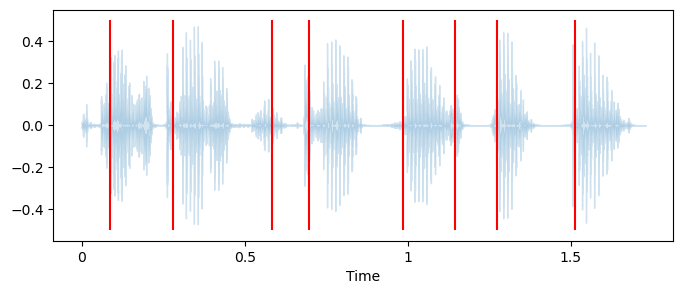

In [54]:
# Extract onset timestamps of words
onsets = librosa.onset.onset_detect(
    y=y, sr=sr, units="time", hop_length=128, backtrack=False
)

# Plot onsets together with waveshow plot
plt.figure(figsize=(8, 3))
librosa.display.waveshow(y=y, sr=sr, alpha=0.2, axis="time")
for o in onsets:
    plt.vlines(o, -0.5, 0.5, colors="r")

Therefore, one feature we could extract is the number of onsets detected in a audio sample.

In [55]:
""" Should be 7 not 8? """

' Should be 7 not 8? '

In [56]:
number_of_words = len(onsets)
number_of_words

8

Length of an audio recording
---
Very much related to this is the length of an audio recording. The longer the recording, the more words can be spoken. So let’s compute the length of the recording and the speed at which words are spoken.

In [57]:
# Computes duration in seconds
duration = len(y) / sr
duration

1.728

In [58]:
# Computes number of words per second
words_per_second = number_of_words / duration
words_per_second

4.62962962962963

Tempo
---
Language is a very melodic signal, and each of us has a unique way and speed of speaking. Therefore, another feature that we could extract is the tempo of our speech, i.e. the number of beats that can be detected in an audio signal.

In [59]:
# Computes the tempo of a audio recording
tempo = librosa.beat.tempo(y=y, sr=sr, start_bpm=10)
tempo

C:\Users\louis\AppData\Local\Temp\ipykernel_3644\1450397658.py:2: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=y, sr=sr, start_bpm=10)


array([41.66666667])

In [60]:
# Computes the tempo of a audio recording
tempo = librosa.feature.rhythm.tempo(y=y, sr=sr, start_bpm=10)
tempo

array([41.66666667])

Fundamental frequency
---
The fundamental frequency is the lowest frequency at which a periodic sound appears. In music this is also known as pitch. In the spectrogram plots that we saw before, the fundamental frequency (also called f0) is the lowest bright horizontal strip in the image. While the repetition of the strip pattern above this fundamental are called harmonics.

To better illustrate what we exactly mean, let’s extract the fundamental frequency and plot them in our spectrogram.

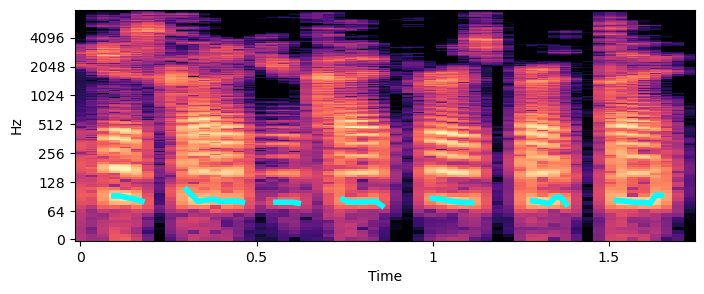

In [61]:
# Extract fundamental frequency using a probabilistic approach
f0, _, _ = librosa.pyin(y, sr=sr, fmin=10, fmax=1500, frame_length=1024)

# Establish timepoint of f0 signal
timepoints = np.linspace(0, duration, num=len(f0), endpoint=False)

# Plot fundamental frequency in spectrogram plot
plt.figure(figsize=(8, 3))
x_stft = np.abs(librosa.stft(y))
x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)
librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log")
plt.plot(timepoints, f0, color="cyan", linewidth=4)
plt.show()

This seems about write, but how can we now use that for feature engineering? Well, what we could do is compute specific characteristics of this f0.

In [62]:
# Computes mean, median, 5%- and 95%-percentile value of fundamental frequency
f0_values = [
    np.nanmean(f0),
    np.nanmedian(f0),
    np.nanstd(f0),
    np.nanpercentile(f0, 5),
    np.nanpercentile(f0, 95),
]
f0_values

[82.63164681884764,
 80.69649525479105,
 5.812585693334871,
 76.82983560408034,
 93.15213348152254]

>There are of course many more audio feature extraction techniques that you could explore. For a nice summary of a few, check out <a href="https://musicinformationretrieval.com/#Signal-Analysis-and-Feature-Extraction">this link.</a>

Summary
---
In this unit we learned how audio data can be loaded and visualized and what the different ways we can represent it mean. We also saw what kind of cleaning step we potentially could perform on audio data, and explored a few feature engineering steps we could conduct to gain more insights into our dataset.

In the next unit we will use all of this insight to perform an exploratory data analysis (EDA) on our audio dataset, followed by the training of some machine learning models with which we will try to predict the gender and age of a speaker.